In [2]:
# Connection
import mysql.connector
import sys

# Utility
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Preprocessing
# import string
from nltk import *
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger') #pour pos_tag

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import wordnet as wn

# Modelling
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D , Activation, InputLayer, LSTM
from tensorflow.keras.layers import Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import (classification_report, confusion_matrix, 
                            f1_score,accuracy_score, precision_score, 
                             recall_score, roc_auc_score) 

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
def connect():
    try:
        cnx = mysql.connector.connect(host="localhost",user="root",password="root",auth_plugin='mysql_native_password',database="sentiment_analysis")
    except mysql.connector.Error as err:
        cnx = False
        print(err)
        sys.exit(1)
    finally:
        return cnx

In [4]:
conn = connect()
conn
cursor = conn.cursor()

In [6]:
def create_dataframe():
    cursor.execute("""  SELECT *
                    FROM clothing_reviews; """)
    rows = cursor.fetchall()
    df = pd.DataFrame(rows,columns=['Index','Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'])
    df = df.set_index('Index')
    df = df.replace('',np.nan,regex = True)
    return df

In [7]:
df_ori = create_dataframe()

# Cleaning

In [8]:
#Suppression de 845 données car il nous faut absolument TOUTES les Review Text
df_ori.dropna(subset=['Review Text'], inplace=True)
# df_ori.isna().sum()

In [9]:
df = df_ori[["Review Text","Recommended IND"]]

In [12]:
stop_words = stopwords.words('english')

In [13]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('V'):
        return wn.VERB
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    else:
        return wn.NOUN

In [14]:
def cleaning(data):
    
    #1. Tokenize
    text_tokens = word_tokenize(data.replace("'", "").lower()) 
        
    #2. Remove Puncs
    tokens_without_punc = [w for w in text_tokens if w.isalpha()]  
    
    #3. Removing Stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]
    
    #4. Lemmatize
    POS_tagging = pos_tag(tokens_without_sw)
    wordnet_pos_tag=[]
    wordnet_pos_tag = [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in POS_tagging]
    wnl = WordNetLemmatizer()
    lemma = [wnl.lemmatize(word, tag) for word, tag in wordnet_pos_tag]
    
    return " ".join(lemma)

In [15]:
# df['Document'] = df['Review Text'].apply(cleaning)

C:\Users\Admin\AppData\Local\Temp\ipykernel_77020\4105619847.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Document'] = df['Review Text'].apply(cleaning)


,Review Text,Recommended IND,Document
Index,,,
1,Absolutely wonderful - silky and sexy and comf...,1,absolutely wonderful silky sexy comfortable
2,Love this dress! it's sooo pretty. i happene...,1,love dress sooo pretty happen find store im gl...
3,I had such high hopes for this dress and reall...,0,high hope dress really wanted work initially o...
4,"I love, love, love this jumpsuit. it's fun, fl...",1,love love love jumpsuit fun flirty fabulous ev...
5,This shirt is very flattering to all due to th...,1,shirt flatter due adjustable front tie perfect...
...,...,...,...
23482,I was very happy to snag this dress at such a ...,1,happy snag dress great price easy slip flatter...
23483,"It reminds me of maternity clothes. soft, stre...",1,reminds maternity clothes soft stretchy shiny ...
23484,"This fit well, but the top was very see throug...",0,fit well top see never would work im glad able...


In [ ]:
# df.to_csv('./datasets/df_cleaned.csv')

In [5]:
df = pd.read_csv("./datasets/df_cleaned.csv")

# Modelling

In [6]:
X = df["Document"].values
y = df["Recommended IND"].values

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 101)

In [13]:
#Parameters

TOKENIZER_NUM_WORDS = None #None by default

SEQUENCE_LENGTH = 300 #None by default


# model



EPOCHS = 30
BATCH_SIZE = 1024

In [14]:
%%time

#Tokenize

tokenizer = Tokenizer(num_words=TOKENIZER_NUM_WORDS)
tokenizer.fit_on_texts(X_train)
# train = tokenizer.texts_to_sequences(df["inputs"])

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 10207
CPU times: total: 734 ms
Wall time: 754 ms


In [15]:
%%time
X_train_padseq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=SEQUENCE_LENGTH)
X_test_padseq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=SEQUENCE_LENGTH)

CPU times: total: 750 ms
Wall time: 757 ms


In [16]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [17]:
print("X_train_padseq", X_train_padseq.shape)
print("y_train", y_train.shape)
print()
print("X_test_padseq", X_test_padseq.shape)
print("y_test", y_test.shape)

X_train_padseq (18112, 300)
y_train (18112, 1)

X_test_padseq (4529, 300)
y_test (4529, 1)


In [18]:
# input_shape = x_train.shape[1]
input_shape = X_train_padseq.shape[1]
print(input_shape)

300


In [ ]:
# embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
# for word, i in tokenizer.word_index.items():
#   if word in w2v_model.wv:
#     embedding_matrix[i] = w2v_model.wv[word]
# print(embedding_matrix.shape)

In [ ]:
# embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [43]:
lstm_model = Sequential()
lstm_model.add(InputLayer(input_shape=(input_shape,)))
lstm_model.add(Embedding(vocab_size,SEQUENCE_LENGTH,input_length=input_shape))
lstm_model.add(LSTM(10, return_sequences=True)) #return sequences ?
lstm_model.add(Flatten())
lstm_model.add(Dense(1, activation="sigmoid"))

In [46]:
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 300)          3062100   
                                                                 
 lstm_1 (LSTM)               (None, 300, 10)           12440     
                                                                 
 flatten (Flatten)           (None, 3000)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 3001      
                                                                 
Total params: 3,077,541
Trainable params: 3,077,541
Non-trainable params: 0
_________________________________________________________________


In [47]:
#compile the model
lstm_model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

In [59]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, restore_best_weights=True)

In [ ]:
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='auto', patience=5,restore_best_weights=True)

In [ ]:
# [ EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [ ]:
# early_stopping = callbacks.EarlyStopping(
#     patience=20,
#     min_delta=0.001,
#     restore_best_weights=True,
# )

In [60]:
%%time
history = lstm_model.fit(X_train_padseq, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.3,
                    callbacks=[early_stopping])

Epoch 1/30
13/13 [==============================] - 27s 2s/step - loss: 0.0109 - accuracy: 0.9972 - val_loss: 0.8884 - val_accuracy: 0.8526
Epoch 2/30
13/13 [==============================] - 27s 2s/step - loss: 0.0100 - accuracy: 0.9973 - val_loss: 0.9020 - val_accuracy: 0.8539
Epoch 3/30
13/13 [==============================] - 27s 2s/step - loss: 0.0091 - accuracy: 0.9976 - val_loss: 0.9262 - val_accuracy: 0.8526
Epoch 4/30
13/13 [==============================] - 27s 2s/step - loss: 0.0085 - accuracy: 0.9978 - val_loss: 0.9407 - val_accuracy: 0.8531
Epoch 5/30
13/13 [==============================] - 27s 2s/step - loss: 0.0079 - accuracy: 0.9982 - val_loss: 0.9576 - val_accuracy: 0.8544
Epoch 6/30
13/13 [==============================] - 27s 2s/step - loss: 0.0074 - accuracy: 0.9983 - val_loss: 0.9800 - val_accuracy: 0.8533
CPU times: total: 7min 50s
Wall time: 2min 42s


In [ ]:
# %%time
# history = model.fit(x_train, y_train,
#                     batch_size=BATCH_SIZE,
#                     epochs=EPOCHS,
#                     validation_split=0.1,
#                     verbose=1,
#                     callbacks=callbacks)

In [ ]:
# model = Sequential()
# model.add(embedding_layer)
# model.add(Dropout(0.5))
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(1, activation='sigmoid'))

# model.summary()

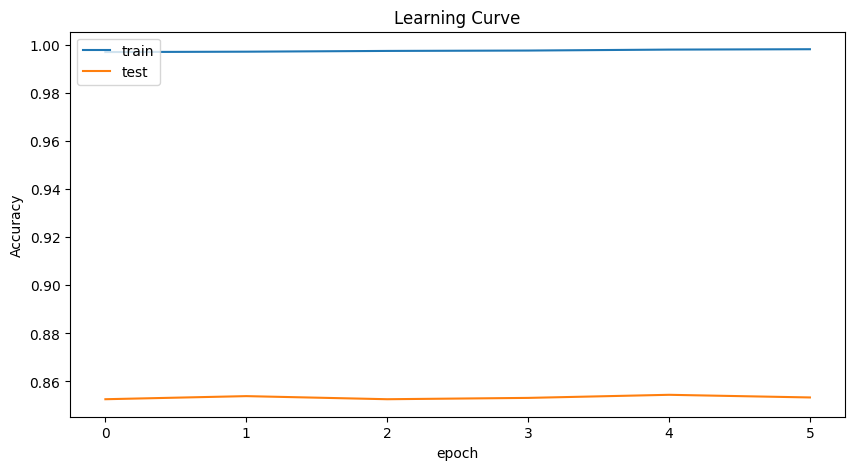

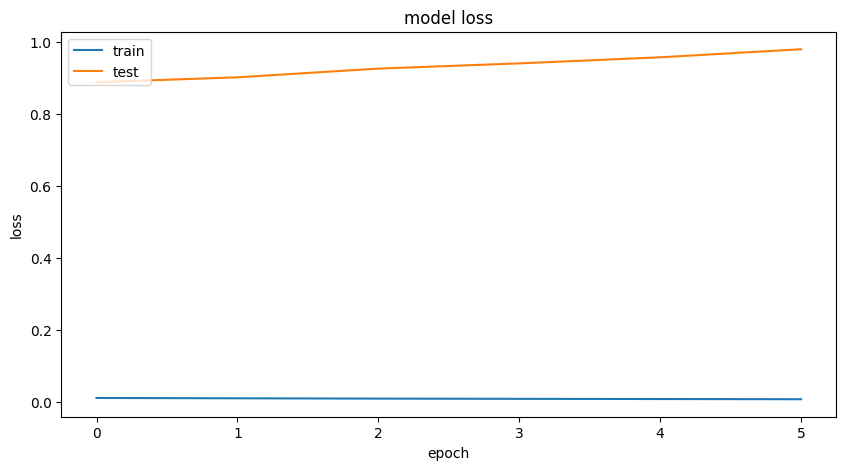

In [61]:
plt.figure(figsize=(10,5))

# summarize history for mae
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Learning Curve')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [194]:
def save_model(file_name):
#     with open(f"./pickle_preprocess/{file_name}.pickle", 'wb') as handle:
#         pickle.dump(vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Prediction

In [76]:
pred_train_lstm = lstm_model.predict(X_train_padseq)
pred_test_lstm = lstm_model.predict(X_test_padseq)

142/142 [==============================] - 6s 39ms/step


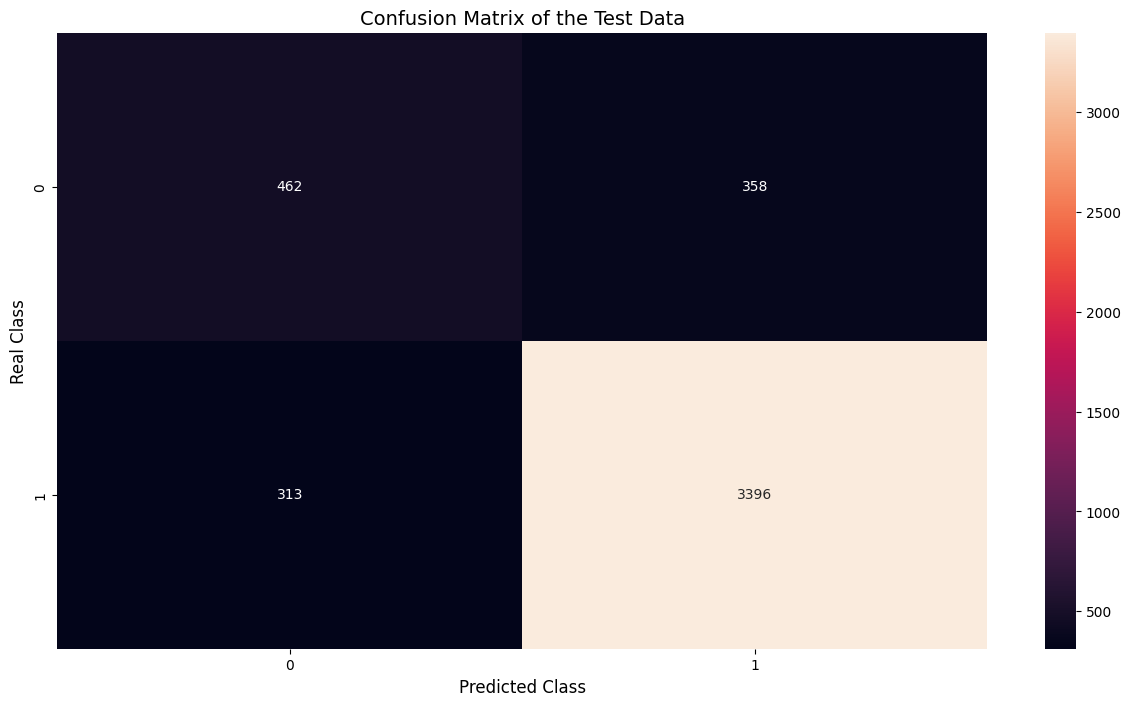

In [84]:
for i, x in enumerate(pred_test_lstm):
    if 0 <= x < 0.49:
        pred_test_lstm[i] = 0
    else:
        pred_test_lstm[i] = 1

for i, x in enumerate(pred_train_lstm):
    if 0 <= x < 0.49:
        pred_train_lstm[i] = 0
    else:
        pred_train_lstm[i] = 1

conf_mat = confusion_matrix(y_true=y_test, y_pred=pred_test_lstm)
plt.figure(figsize=(15, 8))
sns.heatmap(conf_mat, annot=True, fmt='g')
plt.title('Confusion Matrix of the Test Data', fontsize=14)
plt.ylabel('Real Class', fontsize=12)
plt.xlabel('Predicted Class', fontsize=12)
plt.show()

In [85]:
def predict(text):
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = lstm_model.predict([x_test])

    return {"Texte": text, "Recommendation": "Recommandé" if score > 0.5 else "Non Recommandé", "Score": float(score)}  

In [92]:
%%time
predict("I hate that dress")

1/1 [==============================] - 0s 59ms/step
CPU times: total: 172 ms
Wall time: 155 ms


{'Texte': 'I hate that dress',
 'Recommendation': 'Non Recommandé',
 'Score': 0.2860144078731537}

In [88]:
print(classification_report(y_test, pred_test_lstm))

              precision    recall  f1-score   support

           0       0.60      0.56      0.58       820
           1       0.90      0.92      0.91      3709

    accuracy                           0.85      4529
   macro avg       0.75      0.74      0.74      4529
weighted avg       0.85      0.85      0.85      4529



In [89]:
accuracy_score(y_test, pred_test_lstm)

0.8518436741002429

In [93]:
# lstm_model.save('./model_pkl/lstm_model_first.h5')

In [94]:
# pickle.dump(tokenizer, open("./preprocess_pkl/tokenizer.pkl", "wb"), protocol=0)

Rééquilibrage des données

Word2Vec

In [ ]:
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

##### Exemple précédent

In [ ]:
pipeline = Pipeline([("acp",pca_select),('svc_tune',svc_tune)])

In [ ]:
# svd_pipe2 = TruncatedSVD()
# svc_pipe2 = svm.SVC(kernel='rbf')
# pipeline_svd = Pipeline(steps=[('svd2', svd_pipe2), ('svc2', svc_pipe2)])

In [ ]:
# param_grid = [
#     {
#         'svd2__n_components': [25,30,35,40,45,50,75,100,150,200],
#         'svc2__C':[1E-10,1E-8,1E-6,1E-4,1E-2,1E-1,1,1E2,1E4,1E6,1E8,1E10],
#         'svc2__gamma':[1E-10,1E-8,1E-6,1E-4,1E-2,1E-1,1,1E2,1E4,1E6,1E8,1E10]
#     }
# ]

In [ ]:
# searchSVD = GridSearchCV(pipeline_svd, param_grid, n_jobs=-1, verbose=3,cv=5)#n_jobs=-1 permet d'utiliser toutes les capacités de la machine
# searchSVD.fit(X_train, y_train)

In [ ]:
# param_grid = dict(epochs=[10,20,30])
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
# grid_result = grid.fit(X, Y)

###### Exemple Kaggle

In [ ]:
# batch_size = [16, 32]
# epochs = [10, 20]
# optimizers = ['adam', 'rmsprop']
# param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer=optimizers)
# param_grid

In [ ]:
def LSTM_Model(optimizer='adam'):
    model = Sequential()
    model.add(InputLayer(input_shape=(17, 1)))
    model.add(Dense(64, activation='relu'))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

tf.random.set_seed(111)

model = KerasClassifier(build_fn=LSTM_Model, verbose=1)

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

##### GridSearchCV

In [3]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [4]:
batch_size = [16,32,64,128,256,512,1024]
epochs = [10,15,20,25,30]
optimizers = ['adam', 'rmsprop']
param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer=optimizers)
param_grid

{'batch_size': [16, 32, 64, 128, 256, 512, 1024],
 'epochs': [10, 15, 20, 25, 30],
 'optimizer': ['adam', 'rmsprop']}

In [23]:
def LSTM_Model(optimizer='adam'):
    lstm_model = Sequential()
    lstm_model.add(InputLayer(input_shape=(input_shape,)))
    lstm_model.add(Embedding(vocab_size,SEQUENCE_LENGTH,input_length=input_shape))
    lstm_model.add(LSTM(10, return_sequences=True)) #return sequences ?
    lstm_model.add(Flatten())
    lstm_model.add(Dense(1, activation="sigmoid"))
    lstm_model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["f1_score"])
    return lstm_model

In [24]:
model = KerasClassifier(build_fn=LSTM_Model, verbose=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, verbose=3, cv=5)

C:\Users\Admin\AppData\Local\Temp\ipykernel_71660\1607418924.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=LSTM_Model, verbose=1)


In [25]:
%%time
grid_result = grid.fit(X_train_padseq, y_train)

Epoch 1/10
906/906 [==============================] - 161s 173ms/step - loss: 0.3055 - accuracy: 0.8711
Epoch 2/10
906/906 [==============================] - 158s 175ms/step - loss: 0.1911 - accuracy: 0.9215
Epoch 3/10
906/906 [==============================] - 158s 174ms/step - loss: 0.1245 - accuracy: 0.9502
Epoch 4/10
906/906 [==============================] - 157s 173ms/step - loss: 0.0749 - accuracy: 0.9738
Epoch 5/10
906/906 [==============================] - 161s 178ms/step - loss: 0.0439 - accuracy: 0.9847
Epoch 6/10
906/906 [==============================] - 189s 208ms/step - loss: 0.0281 - accuracy: 0.9910
Epoch 7/10
906/906 [==============================] - 181s 200ms/step - loss: 0.0183 - accuracy: 0.9945
Epoch 8/10
906/906 [==============================] - 157s 173ms/step - loss: 0.0136 - accuracy: 0.9961
Epoch 9/10
906/906 [==============================] - 160s 176ms/step - loss: 0.0085 - accuracy: 0.9974
Epoch 10/10
227/227 [==============================] - 8s 30ms/s

KeyboardInterrupt: 

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

##### GridSearchCV exemple 2

In [ ]:
# train the model
def build_model(train, n_back=1, n_predict=1, epochs=10, batch_size=10, neurons=100, activation='relu', optimizer='adam'):
    # define model
    model = Sequential()
    model.add(LSTM(neurons, activation=activation, input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(neurons, activation=activation, return_sequences=True))
    model.add(TimeDistributed(Dense(neurons)))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer=optimizer)
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=1)
    return model
#### Epochs and Batch Size
batch_size = [10, 20]
epochs = [1, 10]

# Optimizer: Select!
#### Optimizer
optimizer = ['Adam', 'Adamax'] #'SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'

#### Neuron Activation Function
activation = ['relu', 'softmax'] #'softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'

#### Tune Dropout Regularization
weight_constraint = [2, 3] #1, 2, 3, 4, 5
dropout_rate = [0.0, 0.1, 0.5, 0.9] #0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9

#### Tune the Number of Neurons in the Hidden Layer
neurons = [100, 200] #10, 50, 100, 200


# create model
model = KerasClassifier(build_fn=build_model(train, n_back, n_predict, epochs, batch_size, neurons, activation, optimizer), verbose=1)

param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer=optimizer,
                  activation=activation,neurons=neurons)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(train_x, train_y)

##### GridSearchCV test 2

In [ ]:
def LSTM_Model(epochs=10, batch_size=10, neurons=10, optimizer='adam'):
    lstm_model = Sequential()
    lstm_model.add(InputLayer(input_shape=(input_shape,)))
    lstm_model.add(Embedding(vocab_size,SEQUENCE_LENGTH,input_length=input_shape))
    lstm_model.add(LSTM(neurons, return_sequences=True)) #return sequences ?
    lstm_model.add(Flatten())
    lstm_model.add(Dense(1, activation="sigmoid"))
    lstm_model.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=["f1_score"])
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=1)
    return lstm_model

In [ ]:
# Epchs and Batch Size
batch_size = [16,32,64,128,256,512,1024]
epochs = [10,15,20,25,30]

# Optimizer
optimizer = ['adam','rmsprop']

# #### Tune Dropout Regularization
# weight_constraint = [2, 3] #1, 2, 3, 4, 5
# dropout_rate = [0.0, 0.1, 0.5, 0.9] #0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9

# Tune the Number of Neurons in the Hidden Layer
neurons = [10,20,30,40 50]

In [ ]:
# create model
tf.random.set_seed(111)
model = KerasClassifier(build_fn=build_model(epochs, batch_size, neurons, activation, optimizer), verbose=1)

In [ ]:
param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer=optimizer,neurons=neurons)
param_grid

In [ ]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1,cv=5)

In [ ]:
grid_result = grid.fit(train_x, train_y)

##### OVER et UnderSampling

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# from imblearn.pipeline import Pipeline

In [ ]:
# over = SMOTE(sampling_strategy=0.1)
# under = RandomUnderSampler(sampling_strategy=0.5)

In [ ]:
# steps = [('o', over), ('u', under)]
# pipeline = Pipeline(steps=steps)

In [ ]:
# # transform the dataset
# X, y = pipeline.fit_resample(X, y)

In [ ]:
# train_size, max_len, embed_size = X_train_emb.shape
# X_train_emb_r = X_train_emb.reshape(train_size, max_len*embed_size)

In [ ]:
smt = SMOTE(sampling_strategy=0.2)
X_smote, y_smote = smt.fit_sample(X_train_padseq, y_train)

In [ ]:
# X_smote = X_smote.reshape((X_smote.shape[0], max_len, embed_size))

In [ ]:
plt.figure(figsize = (10, 8))
plt.subplot(1, 2, 1)
sns.countplot(y_train)
plt.title('Reparition before SMOTE')
plt.subplot(1, 2, 2)
sns.countplot(y_smote)
plt.title('Reparition after SMOTE')
plt.show()

In [ ]:
rus = RandomUnderSampler(random_state=42,sampling_strategy=0.5)
X_rus, y_rus = rus.fit_sample(X_train_padseq, y_train)

In [ ]:
# When float, it corresponds to the desired ratio of the number of samples in the minority class over the number of samples in the majority class after resampling. Therefore, the ratio is expressed as \alpha_{us} = N_{m} / N_{rM} where N_{m} is the number of samples in the minority class and N_{rM} is the number of samples in the majority class after resampling.
# Warning:
# float is only available for binary classification. An error is raised for multi-class classification.
# When str, specify the class targeted by the resampling. The number of samples in the different classes will be equalized. Possible choices are:
# 'majority': resample only the majority class;
# 'not minority': resample all classes but the minority class;
# 'not majority': resample all classes but the majority class;
# 'all': resample all classes;
# 'auto': equivalent to 'not minority'.
# When dict, the keys correspond to the targeted classes. The values correspond to the desired number of samples for each targeted class.
# When callable, function taking y and returns a dict. The keys correspond to the targeted classes. The values correspond to the desired number of samples for each class.

In [ ]:
plt.figure(figsize = (10, 8))
plt.subplot(1, 2, 1)
sns.countplot(y_train)
plt.title('Reparition before RandomUnderSampler')
plt.subplot(1, 2, 2)
sns.countplot(y_smote)
plt.title('Reparition after RandomUnderSampler')
plt.show()